Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

Read the Data

In [2]:
df=pd.read_csv('C:/Users/dell/OneDrive/Desktop/RT_IOT2022.csv')

In [3]:
pd.set_option('display.max_columns',None)
df.head()

,Unnamed: 0,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,0.156193,0.437341,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0.0,33.0,76.0,8.444444,13.115936,0.0,23.0,32.0,6.4,9.555103,0.0,33.0,108.0,7.714286,11.618477,761.985779,2.972918e+07,3.201160e+07,4.001450e+06,1.040307e+07,4438.877106,1.511694e+06,2.026391e+06,506597.757339,680406.147126,761.985779,2.972918e+07,3.201160e+07,2.462431e+06,8.199747e+06,3.373777,3.0,1.666667,25.333333,10.666667,0.0,0.0,0.0,0.0,0.0,0.0,2.282415e+06,2.282415e+06,2.282415e+06,2.282415e+06,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,0.156821,0.439097,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0.0,33.0,76.0,8.444444,13.115936,0.0,23.0,32.0,6.4,9.555103,0.0,33.0,108.0,7.714286,11.618477,247.001648,2.985528e+07,3.188358e+07,3.985448e+06,1.046346e+07,4214.048386,1.576436e+06,1.876261e+06,469065.248966,741351.686212,247.001648,2.985528e+07,3.188358e+07,2.452583e+06,8.242459e+06,3.387323,3.0,1.666667,25.333333,10.666667,0.0,0.0,0.0,0.0,0.0,0.0,2.028307e+06,2.028307e+06,2.028307e+06,2.028307e+06,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,0.155647,0.435811,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0.0,33.0,74.0,8.222222,12.852799,0.0,21.0,30.0,6.0,8.689074,0.0,33.0,104.0,7.428571,11.229866,283.956528,2.984215e+07,3.212405e+07,4.015507e+06,1.044238e+07,2456.903458,1.476049e+06,2.013770e+06,503442.466259,660344.360027,283.956528,2.984215e+07,3.212405e+07,2.471081e+06,8.230593e+06,3.237450,3.0,1.666667,24.666667,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.281904e+06,2.281904e+06,2.281904e+06,2.281904e+06,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,0.156440,0.438033,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0.0,33.0,74.0,8.222222,12.852799,0.0,21.0,30.0,6.0,8.689074,0.0,33.0,104.0,7.428571,11.229866,288.963318,2.991377e+07,3.196106e+07,3.995133e+06,1.048253e+07,3933.906555,1.551892e+06,1.883784e+06,470946.013927,724569.317911,288.963318,2.991377e+07,3.196106e+07,2.458543e+06,8.257786e+06,3.253959,3.0,1.666667,24.666667,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.047288e+06,2.047288e+06,2.047288e+06,2.047288e+06,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,0.156728,0.438839,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0.0,33.0,76.0,8.444444,13.115936,0.0,23.0,32.0,6.4,9.555103,0.

In [4]:
df.shape

(123117, 85)

Drop unnecessary columns

In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

Convert all columns name to lowercase to make it more readable

In [6]:
df.columns=df.columns.str.lower()

Split columns based on Datatype

In [7]:
numerical_columns=list(set(df.describe()))
categorical_columns=list(set(df.columns)-set(numerical_columns))

Check missing values

In [8]:
freq=df[numerical_columns].isnull().sum().reset_index().rename(columns={'index':'col_name',0:'count'})
freq[freq['count']>0]

,col_name,count


In [9]:
freq2=df[categorical_columns].isnull().sum().reset_index().rename(columns={'index':'col_name',0:'count'})
freq2[freq2['count']>0]

,col_name,count


Drop duplicated rows

In [10]:
df.duplicated().sum()

5195

In [11]:
df=df.drop_duplicates()

In [12]:
df.shape

(117922, 84)

Drop columns have 90% or more of same value

In [13]:
def remove_repeat(columns):
    for i in columns:
        freq= df[i].value_counts().reset_index() 
        for item in freq['count']:
            per= item / df[i].shape[0]
            if per >= 0.90 :
                print(i)
                df.drop([i],axis=1,inplace=True)
                break

In [14]:
remove_repeat(numerical_columns)

flow_ece_flag_count
bwd_pkts_payload.min
idle.avg
fwd_bulk_bytes
bwd_urg_flag_count
bwd_iat.std
bwd_init_window_size
idle.std
bwd_bulk_rate
flow_cwr_flag_count
fwd_pkts_payload.std
fwd_urg_flag_count
active.std
fwd_bulk_rate
idle.max
fwd_bulk_packets
flow_fin_flag_count
bwd_bulk_packets
bwd_bulk_bytes
bwd_psh_flag_count
fwd_iat.std
idle.tot
idle.min


In [15]:
remove_repeat(categorical_columns)

update numerical & categorical list

In [16]:
numerical_columns=list(set(df.describe()))
categorical_columns=list(set(df.columns)-set(numerical_columns))

Removing highly correlated features

In [17]:
from scipy.stats import f_oneway

columns_without_target = list(set(numerical_columns))
corr_matrix = df[columns_without_target].corr()
sz = corr_matrix.shape[1]
dropped_col = []

for i in range(sz):
    for j in range(i + 1, sz):
        if abs(corr_matrix.values[i, j]) > 0.8: 
            # For the ith column
            numerical = df[columns_without_target[i]]
            grouped = [numerical[df['attack_type'] == category] for category in df['attack_type'].unique()]
            f_statistic_x, p_value_x = f_oneway(*grouped)
            
            # For the jth column
            numerical = df[columns_without_target[j]]
            grouped = [numerical[df['attack_type'] == category] for category in df['attack_type'].unique()]
            f_statistic_y, p_value_y = f_oneway(*grouped)
            
            # Compare p-values and decide which column to drop
            if p_value_x >= p_value_y:
                dropped_col.append(columns_without_target[j])
            else:
                dropped_col.append(columns_without_target[i])


In [18]:
dropped_col

['bwd_pkts_payload.max',
 'flow_pkts_payload.max',
 'flow_pkts_payload.std',
 'bwd_pkts_payload.avg',
 'fwd_pkts_per_sec',
 'bwd_pkts_per_sec',
 'flow_pkts_per_sec',
 'fwd_iat.tot',
 'flow_iat.tot',
 'bwd_pkts_per_sec',
 'flow_pkts_per_sec',
 'flow_pkts_payload.max',
 'flow_pkts_payload.std',
 'bwd_pkts_payload.avg',
 'flow_iat.tot',
 'fwd_iat.max',
 'flow_iat.avg',
 'fwd_iat.avg',
 'flow_iat.max',
 'flow_pkts_per_sec',
 'active.avg',
 'bwd_data_pkts_tot',
 'flow_ack_flag_count',
 'bwd_header_size_tot',
 'bwd_pkts_tot',
 'bwd_subflow_bytes',
 'bwd_subflow_pkts',
 'bwd_data_pkts_tot',
 'flow_pkts_payload.std',
 'fwd_pkts_payload.max',
 'bwd_pkts_payload.avg',
 'flow_ack_flag_count',
 'bwd_header_size_tot',
 'bwd_pkts_tot',
 'bwd_subflow_bytes',
 'bwd_subflow_pkts',
 'flow_pkts_payload.tot',
 'bwd_iat.max',
 'fwd_header_size_tot',
 'fwd_data_pkts_tot',
 'fwd_header_size_tot',
 'flow_ack_flag_count',
 'flow_ack_flag_count',
 'flow_ack_flag_count',
 'bwd_subflow_pkts',
 'flow_ack_flag_coun

In [19]:
df.drop(dropped_col,axis=1,inplace=True)

update numerical & categorical list

In [20]:
numerical_columns=list(set(df.describe()))
categorical_columns=list(set(df.columns)-set(numerical_columns))

checking for each features whether it follows a normal distribution or not to decide whether to standardize or min-max scale using QQ plot

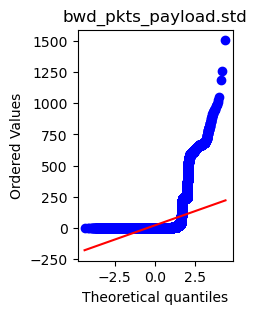

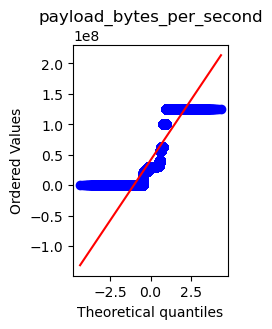

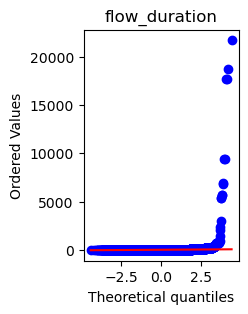

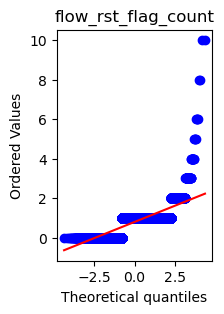

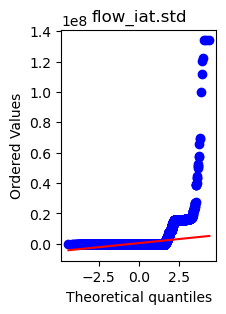

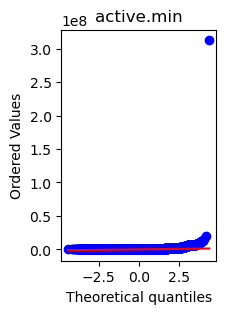

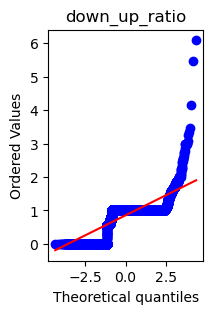

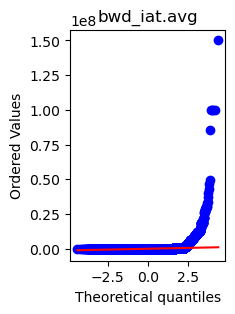

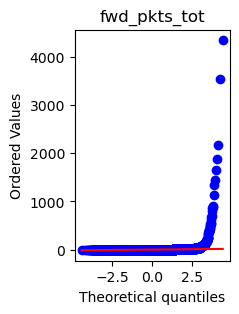

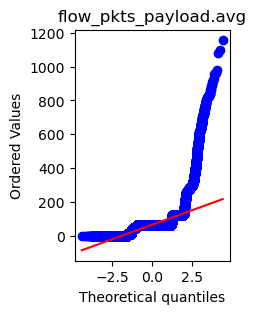

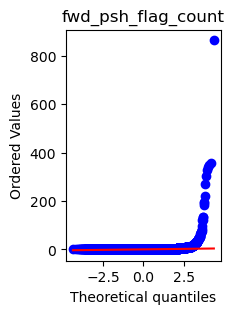

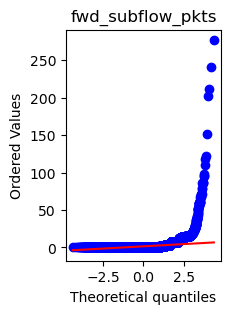

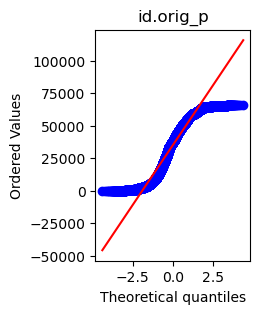

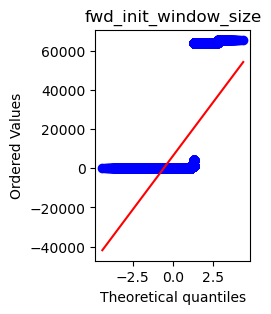

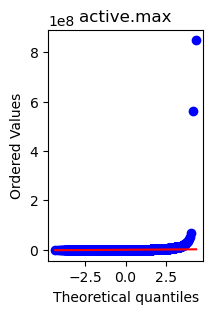

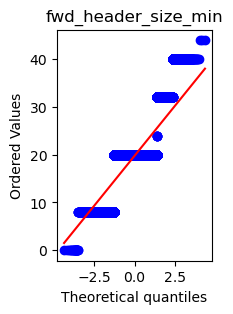

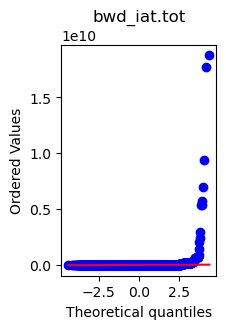

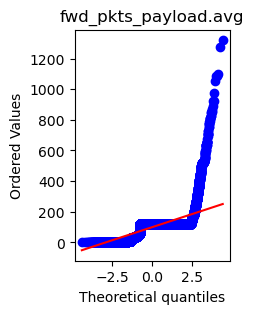

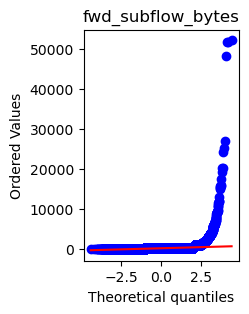

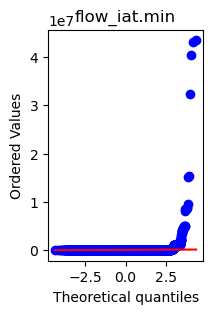

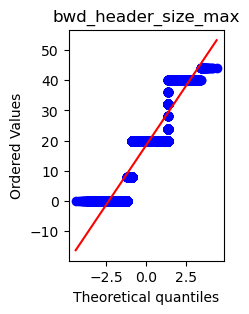

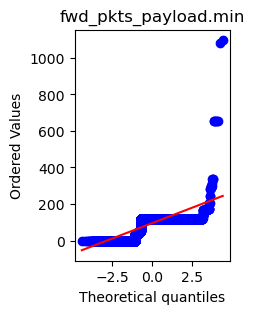

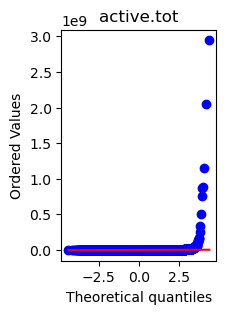

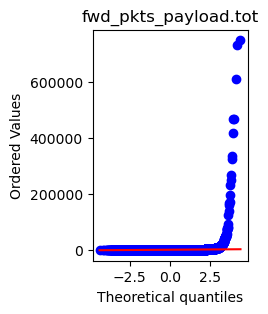

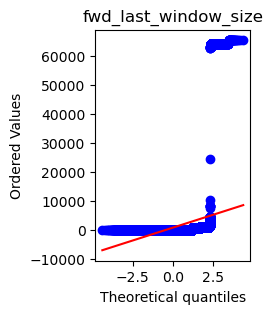

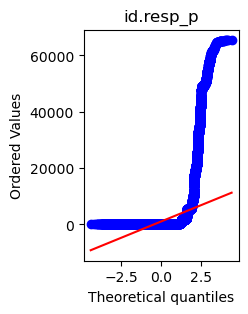

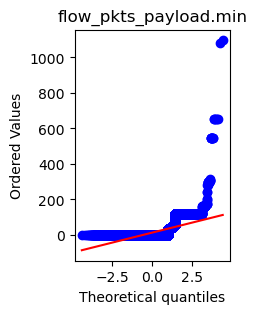

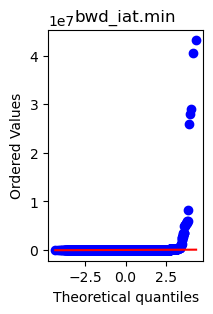

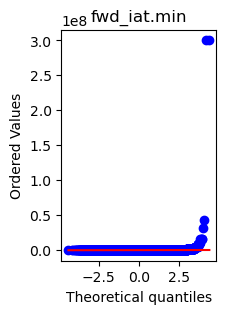

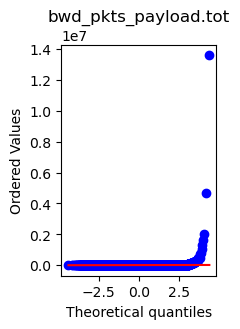

In [21]:
import matplotlib.pyplot as plt
import scipy.stats as stats

for col in numerical_columns:
    plt.figure(figsize=(2,3))
    stats.probplot(df[col],dist="norm",plot=plt)
    plt.title(col)
    plt.show()

Checking for each features whether it follows a normal distribution or not  using shapiro wilk test

In [22]:
from scipy.stats import shapiro
follow_normal_distribution=[]
not_follow_normal_distribution=[]

for col in numerical_columns:
    w,p=shapiro(df[col])
    if(p>0.05):
        follow_normal_distribution.append(col)
    else:
        not_follow_normal_distribution.append(col)

In [23]:
print("Features follow normal distribution",follow_normal_distribution) 

Features follow normal distribution []


Normalize columns don't follow normal distribution using Min_Max_scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler_model=scaler.fit(df[not_follow_normal_distribution])
min_max_scaled_data=pd.DataFrame(scaler_model.transform(df[not_follow_normal_distribution]),columns=not_follow_normal_distribution)

Classify your categorical features into (ordinal and nominal) to decide which features will be label encoded and which features should be OHE

In [25]:
categorical_columns

['attack_type', 'service', 'proto']

In [26]:
nominal_features=['proto','service']
ordinal_features=['attack_type']

One Hot Encoding

In [27]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(sparse=False)
model=encoder.fit(df[nominal_features])
encoded_data=model.transform(df[nominal_features])

a=model.categories_
col_names=[]
for list_ in a:
    for element in list_:
        col_names.append(element)

onehot_df=pd.DataFrame(encoded_data,columns=col_names)

Label Encoding

In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['attack_type'] = label_encoder.fit_transform(df['attack_type'])

In [29]:
label_df=pd.DataFrame(df['attack_type'])

Collect final data

In [30]:
df=pd.concat([min_max_scaled_data.reset_index(drop=True),label_df.reset_index(drop=True),onehot_df.reset_index(drop=True)],axis=1)

In [31]:
df

,bwd_pkts_payload.std,payload_bytes_per_second,flow_duration,flow_rst_flag_count,flow_iat.std,active.min,down_up_ratio,bwd_iat.avg,fwd_pkts_tot,flow_pkts_payload.avg,fwd_psh_flag_count,fwd_subflow_pkts,id.orig_p,fwd_init_window_size,active.max,fwd_header_size_min,bwd_iat.tot,fwd_pkts_payload.avg,fwd_subflow_bytes,flow_iat.min,bwd_header_size_max,fwd_pkts_payload.min,active.tot,fwd_pkts_payload.tot,fwd_last_window_size,id.resp_p,flow_pkts_payload.min,bwd_iat.min,fwd_iat.min,bwd_pkts_payload.tot,attack_type,icmp,tcp,udp,-,dhcp,dns,http,irc,mqtt,ntp,radius,ssh,ssl
0,0.006345,2.681237e-08,1.473265e-03,0.1,0.061136,7.303541e-03,0.091256,0.003374,0.002071,0.006673,0.003472,0.010837,0.590021,0.980240,2.691216e-03,0.727273,0.000108,0.006400,0.000487,1.751287e-05,0.909091,0.0,7.749553e-04,0.000102,0.007660,0.028797,0.0,0.000103,2.537816e-06,0.000002,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.006345,2.692002e-08,1.467374e-03,0.1,0.061455,6.490417e-03,0.091256,0.003124,0.002071,0.006673,0.003472,0.010837,0.780392,0.980240,2.391595e-03,0.727273,0.000100,0.006400,0.000487,5.676888e-06,0.909091,0.0,6.886772e-04,0.000102,0.007660,0.028797,0.0,0.000098,8.226462e-07,0.000002,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.005770,2.572894e-08,1.478441e-03,0.1,0.061366,7.301906e-03,0.091256,0.003353,0.002071,0.006426,0.003472,0.010837,0.683009,0.980240,2.690614e-03,0.727273,0.000107,0.006232,0.000474,6.526230e-06,0.909091,0.0,7.747818e-04,0.000099,0.007660,0.028797,0.0,0.000057,9.457256e-07,0.000002,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.005770,2.586014e-08,1.470939e-03,0.1,0.061569,6.551155e-03,0.091256,0.003137,0.002071,0.006426,0.003472,0.010837,0.929168,0.980240,2.413976e-03,0.727273,0.000100,0.006232,0.000474,6.641302e-06,0.909091,0.0,6.951220e-04,0.000099,0.007660,0.028797,0.0,0.000091,9.624008e-07,0.000002,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.006345,2.690418e-08,1.468238e-03,0.1,0.061366,6.680332e-03,0.091256,0.003223,0.002071,0.006673,0.003472,0.010837,0.779538,0.980240,2.461575e-03,0.727273,0.000103,0.006400,0.000487,8.915345e-06,0.909091,0.0,7.088285e-04,0.000102,0.007660,0.028797,0.0,0.000070,1.291936e-06,0.000002,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117917,0.000000,0.000000e+00,2.761371e-10,0.1,0.000000,1.907300e-08,0.164260,0.000000,0.000230,0.000000,0.001157,0.003612,0.904051,0.015625,7.028038e-09,0.454545,0.000000,0.000000,0.000000,1.369905e-07,0.454545,0.0,2.023774e-09,0.000000,0.015625,0.968527,0.0,0.000000,0.000000e+00,0.000000,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117918,0.000000,0.000000e+00,3.221600e-10,0.1,0.000000,2.212468e-08,0.164260,0.000000,0.000230,0.000000,0.001157,0.003612,0.904051,0.015625,8.152525e-09,0.454545,0.000000,0.000000,0.000000,1.589090e-07,0.454545,0.0,2.347579e-09,0.000000,0.015625,0.988285,0.0,0.000000,0.000000e+00,0.000000,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117919,0.000000,0.000000e+00,2.761371e-10,0.1,0.000000,1.907300e-08,0.164260,0.000000,0.000230,0.000000,0.001157,0.003612,0.904051,0.015625,7.028038e-09,0.454545,0.000000,0.000000,0.000000,1.369905e-07,0.454545,0.0,2.023774e-09,0.000000,0.015625,0.989157,0.0,0.000000,0.000000e+00,0.000000,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117920,0.000000,0.000000e+00,2.761371e-10,0.1,0.000000,1.907300e-08,0.164260,0.000000,0.000230,0.000000,0.001157,0.003612,0.904051,0.015625,7.028038e-09,0.454545,0.000000,0.000000,0.000000,1.369905e-07,0.454545,0.0,2.023774e-09,0.000000,0.015625,0.994051,0.0,0.000000,0.000000e+00,0.000000,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check for unbalanced data

In [32]:
df['attack_type'].value_counts() # there are unbalanced classes

attack_type
2     90089
10     7654
0      7625
3      4142
8      2584
9      2010
6      2000
7      1002
1       533
11      219
4        36
5        28
Name: count, dtype: int64

split data to x,y

In [33]:
x=df.drop(['attack_type'],axis=1)
y=df['attack_type']

In [34]:
x.columns

Index(['bwd_pkts_payload.std', 'payload_bytes_per_second', 'flow_duration',
       'flow_rst_flag_count', 'flow_iat.std', 'active.min', 'down_up_ratio',
       'bwd_iat.avg', 'fwd_pkts_tot', 'flow_pkts_payload.avg',
       'fwd_psh_flag_count', 'fwd_subflow_pkts', 'id.orig_p',
       'fwd_init_window_size', 'active.max', 'fwd_header_size_min',
       'bwd_iat.tot', 'fwd_pkts_payload.avg', 'fwd_subflow_bytes',
       'flow_iat.min', 'bwd_header_size_max', 'fwd_pkts_payload.min',
       'active.tot', 'fwd_pkts_payload.tot', 'fwd_last_window_size',
       'id.resp_p', 'flow_pkts_payload.min', 'bwd_iat.min', 'fwd_iat.min',
       'bwd_pkts_payload.tot', 'icmp', 'tcp', 'udp', '-', 'dhcp', 'dns',
       'http', 'irc', 'mqtt', 'ntp', 'radius', 'ssh', 'ssl'],
      dtype='object')

split data to train,test

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

Train SVM model

In [36]:
from sklearn.svm import SVC
svm=SVC(kernel='linear',decision_function_shape='ovr',class_weight='balanced')
svm.fit(x_train,y_train)

SVC(class_weight='balanced', kernel='linear')

In [37]:
def predict(test):
    y_pred=svm.predict(test)
    return y_pred

In [38]:
y_pred=predict(x_test)

In [39]:
from sklearn.metrics import classification_report
report=classification_report(y_pred,y_test)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1141
           1       0.99      0.70      0.82       145
           2       1.00      1.00      1.00     18022
           3       1.00      1.00      1.00       854
           4       0.86      0.26      0.40        23
           5       0.75      0.43      0.55         7
           6       1.00      0.68      0.81       555
           7       1.00      0.99      0.99       217
           8       0.93      1.00      0.96       467
           9       0.52      1.00      0.69       192
          10       0.96      0.78      0.86      1916
          11       0.73      0.72      0.73        46

    accuracy                           0.97     23585
   macro avg       0.87      0.79      0.80     23585
weighted avg       0.98      0.97      0.97     23585



Save model in pickle file

In [40]:
import pickle
with open('attack model.sav','wb') as file:
  pickle.dump(svm,file)